<a href="https://colab.research.google.com/github/nojihun/project1/blob/main/crnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OCR model for reading Captchas

**Description:** How to implement an OCR model using CNNs, RNNs and CTC loss.

## Setup

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
from google.colab import drive

drive.mount('/content/drive')
directory1 = '/content/drive/MyDrive/captcha' 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


데이터 살펴보기

In [ ]:


data_dir = Path( '/content/drive/MyDrive/captcha/')

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))[:10000]
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)

print("이미지 갯수: ", len(images))
print("라벨 갯수: ", len(labels))
print("문자 갯수: ", len(characters))
print("각 문자들: ", characters)

batch_size = 16


img_width = 200
img_height = 50

downsample_factor = 4


max_length = max([len(label) for label in labels])


Number of images found:  10000
Number of labels found:  10000
Number of unique characters:  60
Characters present:  {'O', 'V', 'B', 'v', 'K', 'd', 'J', '6', 'c', 'e', 'n', 'f', 't', '1', 'C', 'h', 'F', 'A', 'm', 's', '3', 'q', 'G', 'j', 'E', 'T', 'L', '9', '7', 'i', 'H', 'l', 'N', 'W', 'R', 'Q', 'Z', 'Y', 'z', 'k', 'u', 'X', 'M', 'r', '8', 'b', 'p', 'S', '4', '5', 'P', 'y', 'x', '2', 'w', 'a', 'I', 'g', 'D', 'U'}


## Preprocessing

In [ ]:


char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)


num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

#데이터 분할
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. 데이터 전체를 받고
    size = len(images)
    # 2. 데이터 셋의 인덱스를 담은 np.array를 만들고
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3.트렌인 크기를 정하고
    train_samples = int(size * train_size)
    # 4. 트레인 세트와 유효 세트로 나눈다.
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. 이미지를 읽는다.
    img = tf.io.read_file(img_path)
    # 2. 이미지를 png로 변화하고 grayscale로 변화시키낟.
    img = tf.io.decode_png(img, channels=1)
    # 3. 0,255인 정수 범위를 0,1로 바꾼다.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. 이미지 사이즈를 바꾼다.
    img = tf.image.resize(img, [img_height, img_width])
    # 5. 이미지의 가로와 세로를 바꾼다. 이미지의 가로와 시간 차원을 대응시키고 싶기 때문에
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. 라벨값의 문자를 숫자로 바꾼다.
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. 딕셔너리에 넣어서 리턴한다.
    return {"image": img, "label": label}


## 데이터 셋 만들기
numpy array를 데이터 셋으로 만들기

In [ ]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

<PrefetchDataset shapes: {image: (None, 200, 50, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>

## 데이터를 시각화

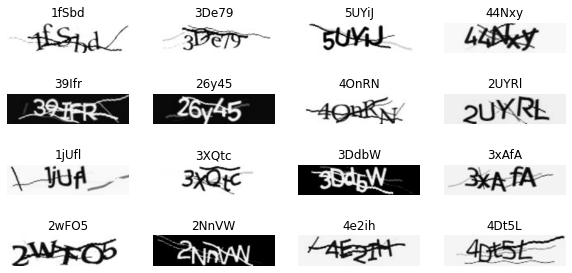

In [ ]:

_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Model

In [ ]:

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # 모델이 훈련하는 경우 로스값을 계산하고 더해준다.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # 테스트 시에는 단지 예측 결과값만 반환한다.
        return y_pred


def build_model():

    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # 첫 conv블럭
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # 두번째 conv 블럭
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    #세번째 conv 블럭
    x = layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool3")(x)

    # 우리는 두 번의 max pool(stride 2, pool size 2)을 사용할 것입니다.  그러므로 feature maps는 4배 downsampled 됩니다. 
    # 마지막 레이어의 필터의 갯수는 128개입니다 
    # 모델의 RNN part에 넣기 전에 Reshape를 해줍시다


    new_shape = ((img_width // 8), (img_height //8) * 128)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)


    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

# 위에서 제작한 CTC loss를 계산하는 CTC layer를 추가합시다.
    output = CTCLayer(name="ctc_loss")(labels, x)

    #모델 정의
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # 모델 컴파일
    model.compile(optimizer=opt)
    return model

model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [ ]:
#모델의 체크포인트를 생성 5에포크 마다 저장하게 한다.
checkpoint_path = '/content/drive/MyDrive/chekpoi/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback= tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1,
                                                period = 5)

In [ ]:
#모델을 다시 가지고 온다.
model.load_weights(checkpoint_path)

## Training

In [ ]:
#모델을 원래는 epoch 수가 200이 넘어가나 어느 정도 되면 학습이 되지 않고 전체적으로 멈춰버렸다.
#그래서 모델을 로드 시키면서 조금씩 조금씩 학습시키게 되면서 epochs 수를 작게 설정했다.
# 실질적인 epoch수는 200이 넘는다.
epochs =5


history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    batch_size = 100,
    callbacks=[cp_callback ],
)


Epoch 1/5
563/563 [==============================] - 28s 49ms/step - loss: 3.6663 - val_loss: 4.0827
Epoch 2/5
563/563 [==============================] - 21s 37ms/step - loss: 3.5528 - val_loss: 4.0217
Epoch 3/5
563/563 [==============================] - 21s 36ms/step - loss: 3.4793 - val_loss: 4.0230
Epoch 4/5
563/563 [==============================] - 21s 36ms/step - loss: 3.4041 - val_loss: 4.0419
Epoch 5/5
561/563 [============================>.] - ETA: 0s - loss: 3.3576
Epoch 00005: saving model to /content/drive/MyDrive/chekpoi/cp.ckpt
563/563 [==============================] - 21s 37ms/step - loss: 3.3588 - val_loss: 4.0219


## Inference

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 50, 12, 128)       73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 25, 6, 128)        0     

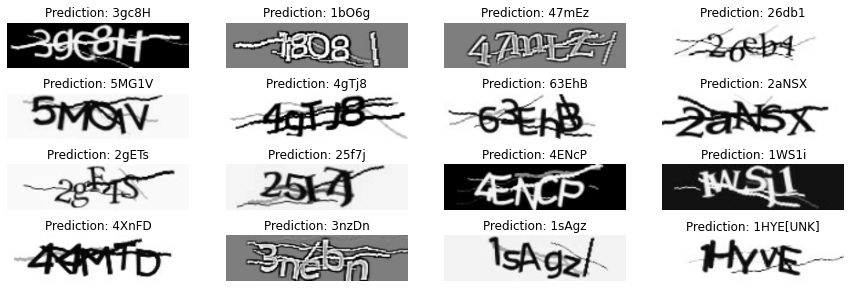

In [ ]:

prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# 결과를 디코딩 해주기
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text



for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 50, 12, 128)       73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 25, 6, 128)        0   

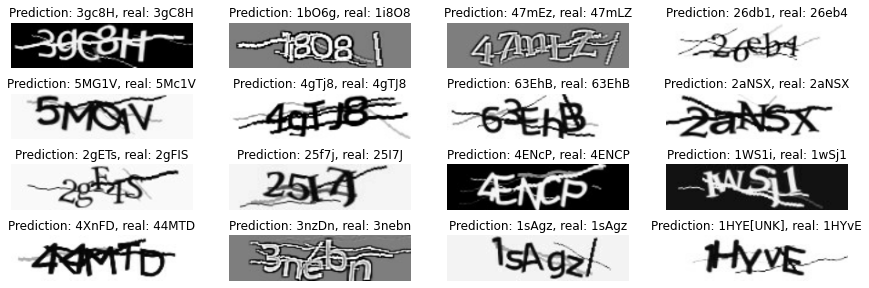

In [ ]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()


def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]

    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text



for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}, real: {orig_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
text = []
for batch in validation_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    text.extend(pred_texts)
print(len(text))

1000


In [ ]:
orig_texts = []
for batch in validation_dataset.take(64):
    batch_labels = batch["label"]

    
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
print(len(orig_texts))


1000


In [ ]:
count = 0
count1=0
count2=0
for i in range(len(text)):
  if text[i]==orig_texts[i]: #다 맞췄는가
    count+= 1
  for z in range(5):
    if text[i][z]==orig_texts[i][z]: #글자 끼리만 비교해서 맞았는가
      count1 +=1
  for z in range(5):
    if text[i].lower()[z]==orig_texts[i].lower()[z]: # 글자를 다 소문자로 바꿔서 비교해보면 맞았는가
      count2 +=1
acuracy = count/1000
a_acur = count1/5000
b_acur = count2/5000

print(f'captcha 예측 정확도: {acuracy}')
print(f'captcha 글자 정확도: {a_acur}')
print(f'captcha 글자(대소문자 안가림)정확도: {b_acur}')



captcha 예측 정확도: 0.225
captcha 글자 정확도: 0.7314
captcha 글자(대소문자 안가림)정확도: 0.8314
